In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

## Generate parameters

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/dimerEnhanceProteinDNA/')
from pathlib import Path
# reaction networks and ode solver
from Simulations.odeSolver.Nonly import rxnNetwork, labels
from Simulations.odeSolver.main import main as numericSolver
# parameter generators
from GenerateParameters import GenParameters
# analytical solution
import analytics as ana
import analyzeEqui as num

In [3]:
parms = GenParameters(
    ifwrite=False, numTargets=0,
    NP0=[0.1], KPN=[200], area3Dto1D=[114],
    KPP=[1e0, 1e3, 1e6], kbPP_fixed=10,
)

In [4]:
equis = numericSolver(parm_df=parms, labels=labels, model=rxnNetwork)

2024-12-17 10:53:24.132544
Number of cores used:  3/36
Finished parallel processing.


In [5]:
pdir = 'DNA:criticDimer//'
Path(pdir).mkdir(parents=True, exist_ok=True)
parms.to_csv(pdir+'/parameters.csv')
equis.to_csv(pdir+'/equilibrium.csv')

In [4]:
# parms['kaPN'] = 2000
# parms['KPN'] = parms['KPN']*10

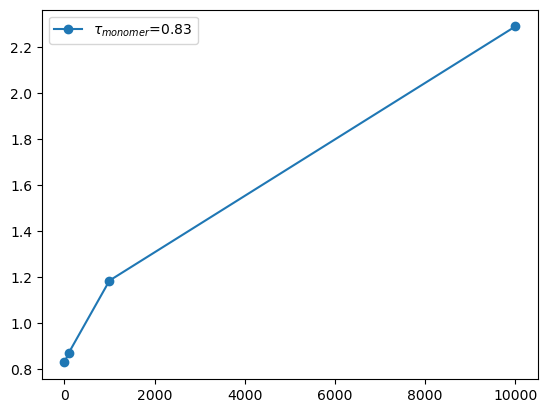

In [5]:
resT = []
for i in range(parms.shape[0]):
    resT.append(ana.ana_resTime_balance(parms.iloc[i], numClusterS=0))
    
plt.plot(
    parms['KPP']*0.6022, resT, 
    label='$\\tau_{monomer}$=%.2f'%min(resT), marker='o'
)
plt.legend()

## Gillespie results validation

In [6]:
sys.path.append('../..')
import analyzeEqui as num

In [ ]:
pfolder = 'S2P01/'


In [8]:
Ndata = 6
Nrep = 3
meanResTs = []
for outi in range(Ndata):
    meanResTi = []
    for repj in range(Nrep):
        with open(pfolder+f'/OUTPUTS_singleS/out_{outi}_r{repj}', 'r') as f:
            readMean = False
            for line in f:
                if line.strip() == '# Mean Residence Time':
                    readMean = True
                elif readMean:
                    meanResTi.append(float(line))
                    break
    meanResTs.append(meanResTi)

In [9]:
# Numerical solutions
# resTs = np.zeros(parm_file.shape[0])
# for iloc in range(parm_file.shape[0]):
# #     parm = parm_file.iloc[iloc]
#     resTs[iloc] = num.calc_resT_modelB(parm_file.iloc[iloc], equi_file.iloc[iloc])

In [10]:
# Generate parameters
# Define the column headers
# units: nm & s
# conversion: 0.6022 nm^-3 = 1 M

def __staticParms(plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False):
    
    kaPN = lambda K: 200
    kbPN = lambda K: kaPN(K)/K
    
    kaPS = lambda K: 1000
    kbPS = lambda K: kaPS(K)/K
    
    V0 = 2.1e4 # nm^3
    VtoL = 1000 # nm^2

    CN0 = 10/V0 # nm^-3
    CS0 = 2/V0
    C0 = 0.6022 # 0.6022 nm^-3 = 1 M 
    
    # whether more dense data points

    nDenseKPN = 0
    nDenseKPP = 0
    nDenseCP0 = 0
    if plotDenseData:
        if denseKPN: nDenseKPN = 43
        if denseKPP: nDenseKPP = 8
        if denseCP0: nDenseCP0 = 10
    
    return kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0
    

def GenerateParameters_or_write(
    filename='', ifwrite=False, 
    plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False
):
    headers = [
        "ID", "CN0", "CS0", "CP0", 
        "KPS", "KPN", "KPP", "gamma", 
        "kaPS", "kaPN", "kaPP", 
        "kbPS", "kbPN", "kbPP"
    ]

    # generate data
    data = []
    number = 0
    kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0, nDenseKPN, nDenseKPP, nDenseCP0 = \
    __staticParms(plotDenseData, denseKPN, denseKPP, denseCP0)

    KPS = 1e3 * 5*2/C0
    CP0 = 0.1/V0
    KPP = np.exp(-23)/C0
    kbPP = lambda K: 10 / (KPP*C0/1e1)**(4/9)
    kaPP = lambda K: K*kbPP(K)
    for KPN in np.logspace(1, 3, 3+2*nDenseKPN)*2.0/C0:
        KPS = 1e3 * KPN
        for area3Dto1D in [10, 100]:
            entry = {
                'ID':number,
                "CN0":CN0,
                "CS0":CS0,
                "CP0":CP0,
                "KPN":np.round(KPN, 10),
                "kaPN":np.round(kaPN(KPN), 10),
                "kbPN":np.round(kbPN(KPN), 10),
                "KPS":np.round(KPS, 10),
                "kaPS":np.round(kaPS(KPS), 10),
                "kbPS":np.round(kbPS(KPS), 10),
                "KPP":np.round(KPP, 10),
                "kaPP":0.0, #np.round(kaPP(KPP), 10),
                "kbPP":np.round(kbPP(KPP), 10),
                "gamma":VtoL/area3Dto1D
            }
            data.append(entry)
            number += 1

    if ifwrite:
        # Specify the output CSV file name
        output_file = filename
        # # Write the data to the CSV file
        import csv
        with open(output_file, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=headers)
            writer.writeheader()
            writer.writerows(data)
        print("CSV file generated successfully!")
    
    return pd.DataFrame(data, columns=headers)

parm_file = GenerateParameters_or_write(
    ifwrite=False, plotDenseData=True, 
    denseKPN=True, denseKPP=False, denseCP0=False,
)

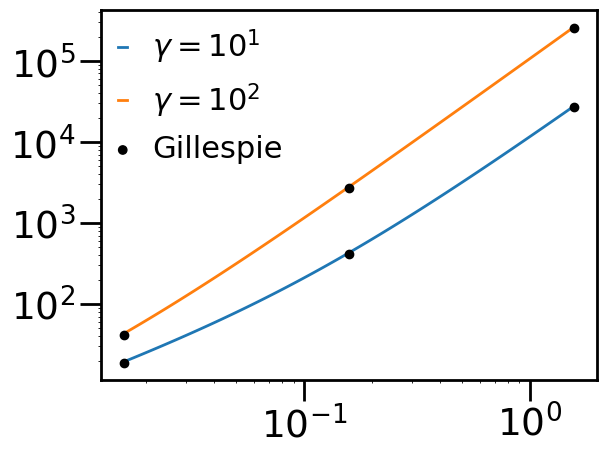

In [12]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
scale = 1.0
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':27*scale}
legend = {'fontsize':22*scale, 'loc':[0.01,0.55], 'handlelength':0.3*scale, 
#           'title':'$\\gamma$', 
          'title_fontsize':22*scale,
         'framealpha':0.0}
# fig = plt.figure(figsize=(3*scale,9*scale))
# ax = fig.add_subplot(111)
ax = plt.gca()
plt.tick_params(length=15*scale, width=2*scale)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2*scale)  # change width
C0 = 0.6022 # nm^-3 -> M
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
linsStyles = ['-', '--']
colors = ['tab:blue', 'tab:orange', 'tab:green']
gamList = np.unique(parm_file['gamma'])
# plot analytical results
for i, gam in enumerate(gamList):
    selected = ((parm_file['gamma']==gam))
    chiN = parm_file['KPN'][selected]*parm_file['CN0'][selected]
    chiS = parm_file['KPS'][selected]*parm_file['CS0'][selected]
    kaStokaN = parm_file['kaPS'][selected]/parm_file['kaPN'][selected]
    CS0toCN0 = parm_file['CS0'][selected]/parm_file['CN0'][selected]
#     ax.plot(
#         chiN,
#         resTs[selected],
#         label='$\\gamma=10^{%.0f}$'%np.log10(gam),
#         color=colors[i], lw=2,
#     )
    ax.plot(
        chiN,
        (chiN+chiS*(1+gam*chiN))/chiN/(1+kaStokaN*CS0toCN0) / parm_file['kbPN'][selected],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
        color=colors[i], lw=2, ls='-'
    )
parm_file = pd.read_csv(pfolder+'/parameters.csv')
# plot Gillespie results
for outi in range(Ndata):
    if meanResTs[outi] == []:
        pass
    else:
        parm = parm_file.iloc[outi]
        plt.errorbar(
            parm['KPN']*parm['CN0'], 
            np.mean(meanResTs[outi]), np.std(meanResTs[outi]),
            ls='', color='black', marker='o',
        )
plt.scatter([],[],ls='', color='black', marker='o',label='Gillespie')
# plt.plot([],[],ls='--', color='black',label='Estimate')
# plt.plot([],[],ls='-', color='black',label='Numeric')
    
ax.loglog()
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.show()

## Numeric and analytical results

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA')
from Simulations.odeSolver.singleS import process_task, labels
from Simulations.odeSolver.main import main as numericSolver
import analyzeEqui as num

In [3]:
np.logspace(1-9,5-9,5)

array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04])

In [3]:
# Generate parameters
# Define the column headers
# units: nm & s
# conversion: 0.6022 nm^-3 = 1 M

def GenerateParameters_or_write(
    filename='', ifwrite=False, 
    plotDenseData=False, denseKPN=True, denseKPP=True, denseCP0=False
):
    headers = [
        "ID", "CN0", "CS0", "CP0", 
        "KPS", "KPN", "KPP", "gamma", 
        "kaPS", "kaPN", "kaPP", 
        "kbPS", "kbPN", "kbPP"
    ]

    # generate data
    data = []
    number = 0
    ########### These two may also change ###########
    nfp = 5 # bps, footprint length of protein
    L = 21 # nm, length of accessible DNA
    #################################################
    VtoL = 1000 # nm^2
    V0 = VtoL*L # nm^3
    # concentrations 
    CN0 = np.floor(3*L/nfp - 2)/V0 # nm^-3
    CS0 = 2/V0
    C0 = 0.6022 # 0.6022 nm^-3 = 1 M 
    # monomer binding
    KPP = 0.0
    kbPP = lambda K: 1e23
    kaPP = lambda K: 0.0
    
    # Remember to tune these kinetic rates
    kaPN = np.round(200/C0, 10) # upper limit 2x10^6
    kbPN = lambda K, kaPN: np.round(kaPN/K, 10)
    
    kaPS = np.round(1000/C0, 10) # upper limit 10^7
    kbPS = lambda K, kaPS: np.round(kaPS/K, 10)
    
    # whether more dense data points

    nDenseKPN = 0
    nDenseKPP = 0
    nDenseCP0 = 0
    if plotDenseData:
        if denseKPN: nDenseKPN = 43
        if denseKPP: nDenseKPP = 20
        if denseCP0: nDenseCP0 = 10

    
#     KPS = 1e3 * 5*2/C0
    CP0 = np.array([0.01, 0.1, 1])[1]/V0
    KPN = 200 / C0
    area3Dto1D = [1, 10, 100][1]
    kaPS = np.round([1e3, 1e5, 1e7], 10)[1]/C0
    for KPN in np.logspace(1, 3, 5+2*nDenseKPN)*2.0/C0:
        KPS = 1e3 * KPN
#     for CP0 in np.logspace(1-9,5-9,17+4*nDenseKPP):
        for kaPN in np.round([2e2, 2e4, 2e6], 10)/C0:
#         for area3Dto1D in [1, 10, 100]:
            entry = {
                'ID':number,
                "CN0":CN0,
                "CS0":CS0,
                "CP0":CP0,
                "KPN":np.round(KPN, 10),
                "kaPN":kaPN,
                "kbPN":kbPN(KPN, kaPN),
                "KPS":np.round(KPS, 10),
                "kaPS":kaPS,
                "kbPS":kbPS(KPS, kaPS),
                "KPP":np.round(KPP, 10),
                "kaPP":kaPP(KPP),
                "kbPP":kbPP(KPP),
                "gamma":VtoL/area3Dto1D
            }
            data.append(entry)
            number += 1

    if ifwrite:
        # Specify the output CSV file name
        output_file = filename
        # # Write the data to the CSV file
        import csv
        with open(output_file, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=headers)
            writer.writeheader()
            writer.writerows(data)
        print("CSV file generated successfully!")
    
    return pd.DataFrame(data, columns=headers)

parm_file = GenerateParameters_or_write(
    ifwrite=False, plotDenseData=True, 
)

In [4]:
parm_num = GenerateParameters_or_write(ifwrite=False, plotDenseData=False)
equi_num = numericSolver(parm_df=parm_num, labels=labels, model=process_task)

2024-09-09 11:45:24.834792
Number of cores used:  15/36
Finished parallel processing.


In [5]:
def calc_resT_survP(parm):
    gam = parm['gamma']
    konS = parm['kaPS']
    kbS = parm['kbPS']
    CS = parm['CS0']
    konN = parm['kaPN']
    kbN = parm['kbPN']
    CN = parm['CN0']
    # calculate tauPN0 and tauPS0
    denom = (gam*konS*CS + gam*konN*CN + kbN + kbS) * kbN*kbS
    tauPN0 = (gam*konS*CS + kbS)*(kbN + kbS + gam*konN*CN) / denom
    tauPS0 = (gam*konN*CN + kbN)*(kbN + kbS + gam*konS*CS) / denom
    # association ratio, p
    p = konN*CN / (konN*CN + konS*CS)
    return p*tauPN0 + (1-p)*tauPS0

def calc_resT_2state(parm):
    gam = parm['gamma']
    konS = parm['kaPS']
    KPS = parm['KPS']
    CS = parm['CS0']
    konN = parm['kaPN']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiN = KPN*CN
    chiS = KPS*CS
    aS_to_aN = konS*CS / (konN*CN)
    return (chiN+chiS*(1+gam*chiN))/chiN/(1+aS_to_aN) / koffN

resT_2s = np.zeros(parm_file.shape[0])
resT_surv = np.zeros(parm_file.shape[0])

for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    resT_2s[iloc] = calc_resT_2state(parm)
    resT_surv[iloc] = calc_resT_survP(parm)

resT_num = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    equi = equi_num.iloc[iloc]
    resT_num[iloc] = num.calc_resT_modelB(parm, equi)

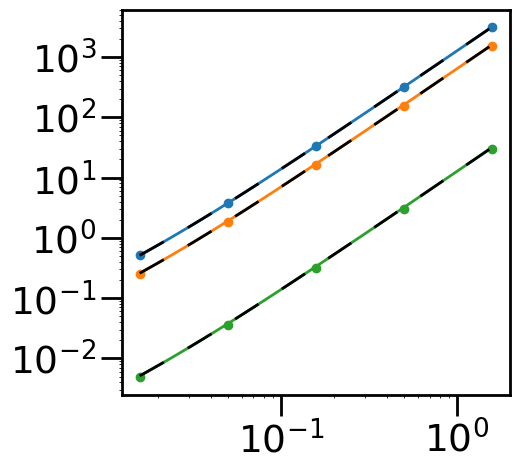

In [6]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
scale = 1.0
labelfont = {'fontsize':20*scale}
tickfont = {'fontsize':27*scale}
legend = {'fontsize':16*scale, 'loc':[0.01,0.6], 'handlelength':0.5*scale, 
          'title':'$k_{on}^N$ ($M^{-1}s^{-1}$)', 'title_fontsize':16*scale,
         'framealpha':0.0}
fig = plt.figure(figsize=(5*scale,5*scale)); ax = fig.add_subplot(111)
plt.tick_params(length=15*scale, width=2*scale)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2*scale)  # change width
C0 = 0.6022 # nm^-3 -> M
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
linsStyles = ['-', '--']
colors = ['tab:blue', 'tab:orange', 'tab:green']
# gamList = np.unique(parm_file['gamma'])
# for i, gam in enumerate(gamList):
#     selected = ((parm_file['gamma']==gam))
#     selected_num = ((parm_num['gamma']==gam))
kanList = np.unique(parm_file['kaPN'])
for i, kaN in enumerate(kanList):
    selected = ((parm_file['kaPN']==kaN))
    selected_num = ((parm_num['kaPN']==kaN))
    ax.plot(
        (parm_file['KPN']*parm_file['CN0'])[selected],
#         parm_file['CP0'][selected]/C0*1e6,
        resT_2s[selected],
#         label='$\\gamma=10^{%.0f}$'%np.log10(gam),
        label='$2\\cdot 10^{%.0f}$'%np.log10(kaN*C0/2),
        color=colors[i], lw=2,
    )
    ax.plot(
        (parm_file['KPN']*parm_file['CN0'])[selected],
#         parm_file['CP0'][selected]/C0*1e6,
        resT_surv[selected],
        color='black', lw=2, ls=(0, (10, 10))
    )
    # numerical solution (true)
    ax.scatter(
        (parm_num['KPN']*parm_num['CN0'])[selected],
#         parm_num['CP0'][selected]/C0*1e6,
        resT_num[selected_num],
        color=colors[i], 
    )

ax.loglog()
# plt.legend(**legend)
plt.xticks(**tickfont)
# plt.ylim([1e-2,2e2])
plt.yticks(**tickfont)
plt.show()

In [137]:
np.unique(parm['CS0']/C0)*1e6

array([158.15027439])

## survival prob

In [16]:
np.log10(parms['KPP']*0.6022)

/home/local/WIN/msang2/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0   -inf
1    2.0
2    3.0
3    4.0
Name: KPP, dtype: float64

In [17]:
1/np.unique(parms['kbPN'])

array([0.83028894])

In [8]:
def readGillespieSurvP(filename):
    with open(filename) as f:
        reading = False
        times = []
        survP = []
        numDiss = 'Not Read'
        for line in f:
            if line.strip() == '# START SURVIVAL PROB':
                reading = True
            elif line.strip() == '# END SURVIVAL PROB':
                reading = False
            elif line.strip() == '# Mean Residence Time':
                meanResT = float(f.readline().strip())
            elif line.strip().startswith('Number of dissociation events:'):
                numDiss = int(line.split(':')[1])
            else:
                if reading:
                    linelist = line.split()
                    times.append(float(linelist[0]))
                    survP.append(float(linelist[1]))
    return np.array(times), np.array(survP), meanResT, numDiss

/tmp/ipykernel_328437/4284028219.py:3: RuntimeWarning: divide by zero encountered in log10
  print('KPP: 10^%.1f'%np.log10(parms['KPP'][i]*0.6022))


KPP: 10^-inf
mean residence time (Gillespie 0~100): 0.78693
mean residence time (Gillespie 100~200): 0.81454
mean residence time (Theory): 0.81454


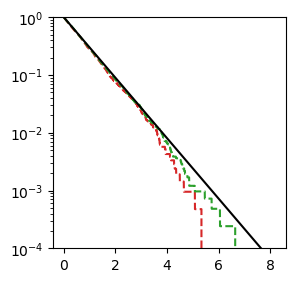

KPP: 10^2.0
mean residence time (Gillespie 0~100): 0.79826
mean residence time (Gillespie 100~200): 0.80539
mean residence time (Theory): 0.80539


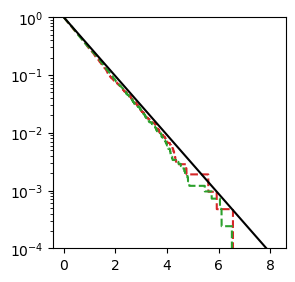

KPP: 10^3.0
mean residence time (Gillespie 0~100): 0.94271
mean residence time (Gillespie 100~200): 1.0375
mean residence time (Theory): 1.0375


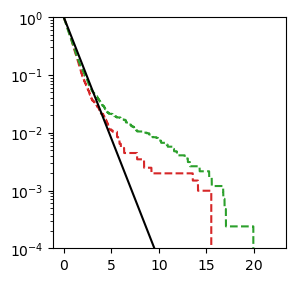

KPP: 10^4.0
mean residence time (Gillespie 0~100): 1.5941
mean residence time (Gillespie 100~200): 1.7438
mean residence time (Theory): 1.7438


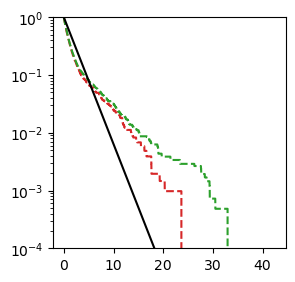

In [26]:
for i in range(4):
    plt.figure(figsize=(3,3))
    print('KPP: 10^%.1f'%np.log10(parms['KPP'][i]*0.6022))
    
    fileName = f'./forNERDSS_nonEqui_0_100//OUTPUTS_Nonly/out_{i}_r0'
    times, survP, meanResT, _ = readGillespieSurvP(fileName)
    plt.plot(times, survP, ls='--', color='tab:red')
    print('mean residence time (Gillespie 0~100):', meanResT)
    
    fileName = f'./forNERDSS_nonEqui//OUTPUTS_Nonly/out_{i}_r0'
    times, survP, meanResT, _ = readGillespieSurvP(fileName)
    plt.plot(times, survP, ls='--', color='tab:green')
    print('mean residence time (Gillespie 100~200):', meanResT)
    
    meanResT_theory = num.calc_resT_modelA(parms.iloc[i], equis.iloc[i])
    print('mean residence time (Theory):', meanResT)
    plt.plot(times, np.exp(-np.array(times)/meanResT_theory), color='black')
    
    plt.semilogy()
    plt.ylim([1e-4,1e0])
    plt.show()

/tmp/ipykernel_402811/1261666839.py:3: RuntimeWarning: divide by zero encountered in log10
  print('KPP: 10^%.1f'%np.log10(parms['KPP'][i]*0.6022))


KPP: 10^-inf
mean residence time (Gillespie 100~1000): 0.82109
mean residence time (Theory): 0.82109


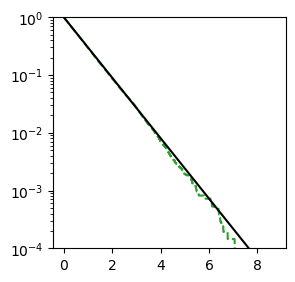

KPP: 10^2.0
mean residence time (Gillespie 100~1000): 0.85375
mean residence time (Theory): 0.85375


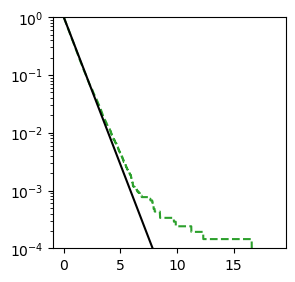

KPP: 10^3.0
mean residence time (Gillespie 100~1000): 1.0317
mean residence time (Theory): 1.0317


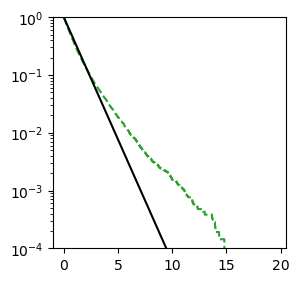

KPP: 10^4.0
mean residence time (Gillespie 100~1000): 1.9045
mean residence time (Theory): 1.9045


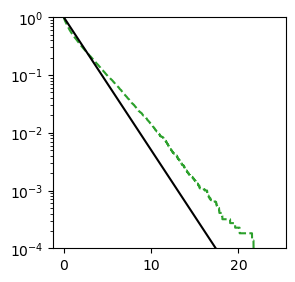

In [9]:
for i in range(4):
    plt.figure(figsize=(3,3))
    print('KPP: 10^%.1f'%np.log10(parms['KPP'][i]*0.6022))
    
    # fileName = f'./forNERDSS_0_100//OUTPUTS_Nonly/out_{i}_r0'
    # times, survP, meanResT, _ = readGillespieSurvP(fileName)
    # plt.plot(times, survP, ls='--', color='tab:red')
    # print('mean residence time (Gillespie 0~100):', meanResT)
    
    fileName = f'./forNERDSS//OUTPUTS_Nonly/out_{i}_r0'
    times, survP, meanResT, _ = readGillespieSurvP(fileName)
    plt.plot(times, survP, ls='--', color='tab:green')
    print('mean residence time (Gillespie 100~1000):', meanResT)
    
    meanResT_theory = num.calc_resT_modelA(parms.iloc[i], equis.iloc[i])
    print('mean residence time (Theory):', meanResT)
    plt.plot(times, np.exp(-np.array(times)/meanResT_theory), color='black')
    
    plt.semilogy()
    plt.ylim([1e-4,1e0])
    plt.show()